In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv
/kaggle/input/parquet-files-amexdefault-prediction/test_data.parquet
/kaggle/input/parquet-files-amexdefault-prediction/train_data.ftr
/kaggle/input/parquet-files-amexdefault-prediction/train_data.parquet
/kaggle/input/parquet-files-amexdefault-prediction/test_data.ftr


## Load dataset

In [3]:
df_train_ = pd.read_feather('../input/parquet-files-amexdefault-prediction/train_data.ftr')
# Keep the latest statement features for each customer
df_train = df_train_.groupby('customer_ID').tail(1).set_index('customer_ID', drop=True).sort_index()

In [4]:
del df_train_
gc.collect()

23

In [5]:
df_test_ = pd.read_feather('../input/parquet-files-amexdefault-prediction/test_data.ftr')
df_test = df_test_.groupby('customer_ID').tail(1).set_index('customer_ID', drop=True).sort_index()

In [6]:
del df_test_
gc.collect()

23

In [7]:
df_label = pd.read_csv('/kaggle/input/amex-default-prediction/train_labels.csv').set_index('customer_ID')

## Basic overview of dataset

In [8]:
print("***** Shape of training data set is *****",df_train.shape)
print("***** Shape of test data set is     *****",df_test.shape)
print("***** Shape of training labels      *****",df_label.shape)

***** Shape of training data set is ***** (458913, 189)
***** Shape of test data set is     ***** (924621, 189)
***** Shape of training labels      ***** (458913, 1)


In [9]:
df_train.head()

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,2018-03-13,0.934570,0.009117,0.009384,1.007812,0.006104,0.135010,0.001604,0.007175,NaN,...,NaN,NaN,NaN,0.007187,0.004234,0.005085,NaN,0.005810,0.002970,0.008530
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,2018-03-25,0.880371,0.178101,0.034698,1.003906,0.006912,0.165527,0.005550,0.005070,NaN,...,NaN,NaN,NaN,0.002981,0.007481,0.007874,NaN,0.003284,0.003170,0.008514
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,2018-03-12,0.880859,0.009705,0.004284,0.812500,0.006451,NaN,0.003796,0.007195,NaN,...,NaN,NaN,NaN,0.007381,0.006622,0.000965,NaN,0.002201,0.000834,0.003445
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,2018-03-29,0.621582,0.001082,0.012566,1.005859,0.007828,0.287842,0.004532,0.009941,NaN,...,NaN,NaN,NaN,0.002705,0.006184,0.001899,NaN,0.008186,0.005558,0.002983
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,2018-03-30,0.872070,0.005573,0.007679,0.815918,0.001247,NaN,0.000231,0.005527,NaN,...,NaN,NaN,NaN,0.002974,0.004162,0.005764,NaN,0.008156,0.006943,0.000905


In [10]:
df_train.info(max_cols=190,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 458913 entries, 0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a to fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba8b115f71cab04681
Data columns (total 189 columns):
 #    Column  Non-Null Count   Dtype   
---   ------  --------------   -----   
 0    S_2     458913 non-null  object  
 1    P_2     455944 non-null  float16 
 2    D_39    458913 non-null  float16 
 3    B_1     458913 non-null  float16 
 4    B_2     458882 non-null  float16 
 5    R_1     458913 non-null  float16 
 6    S_3     373943 non-null  float16 
 7    D_41    458882 non-null  float16 
 8    B_3     458882 non-null  float16 
 9    D_42    59910 non-null   float16 
 10   D_43    324591 non-null  float16 
 11   D_44    436618 non-null  float16 
 12   B_4     458913 non-null  float16 
 13   D_45    458882 non-null  float16 
 14   B_5     458913 non-null  float16 
 15   R_2     458913 non-null  float16 
 16   D_46    363790 non-null  float16 
 17   D_47  

In [13]:
df_train.describe()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
count,455944.000000,4.589130e+05,458913.000000,4.588820e+05,4.589130e+05,373943.000000,4.588820e+05,4.588820e+05,59910.000000,324591.000000,...,16395.000000,1.639500e+04,1.639500e+04,456083.000000,458913.000000,4.560830e+05,80315.000000,456083.000000,458913.000000,456083.000000
mean,NaN,NaN,0.000000,NaN,0.000000e+00,NaN,0.000000e+00,NaN,0.177979,0.000000,...,0.246826,1.412201e-02,1.589355e-01,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.000000
std,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.253662,0.000000,...,0.211792,9.527588e-02,2.609863e-01,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
min,-0.458984,5.960464e-08,-3.570312,1.788139e-07,5.960464e-08,-0.508789,5.960464e-08,5.960464e-08,-0.000240,0.000002,...,0.000009,3.576279e-07,1.788139e-07,0.000000,0.000000,1.192093e-07,-0.011436,0.000000,0.000000,0.000000
25%,0.449219,4.783630e-03,0.008987,7.092285e-02,2.956390e-03,0.127563,3.007889e-03,5.485535e-03,0.031769,0.043335,...,0.009628,2.519608e-03,3.482819e-03,0.003046,0.002552,3.026962e-03,0.200684,0.003033,0.002758,0.003031
50%,0.682617,9.559631e-03,0.033234,8.134766e-01,5.920410e-03,0.164917,6.011963e-03,1.083374e-02,0.108276,0.092407,...,0.254150,5.050659e-03,7.026672e-03,0.006077,0.005119,6.050110e-03,0.385986,0.006065,0.005501,0.006073
75%,0.862305,2.666016e-01,0.153687,1.001953e+00,8.888245e-03,0.264893,8.995056e-03,2.106934e-01,0.230347,0.195068,...,0.258301,7.579803e-03,5.014648e-01,0.009102,0.007675,9.101868e-03,0.573730,0.009094,0.008255,0.009102
max,1.009766,5.000000e+00,1.324219,1.009766e+00,2.759766e+00,3.994141,8.992188e+00,1.596680e+00,4.187500,9.187500,...,1.759766,1.009766e+00,2.505859e+00,1.009766,1.009766,1.339844e+00,2.228516,1.009766,1.343750,4.828125


In [14]:
df_test.head()

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
customer_ID,,,,,,,,,,,,,,,,,,,,,
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,2019-10-12,0.568848,0.121399,0.010780,1.009766,0.006924,0.149414,0.000396,0.003576,0.10376,...,NaN,NaN,NaN,0.005913,0.001250,0.006542,NaN,0.009163,0.003691,0.003220
00001bf2e77ff879fab36aa4fac689b9ba411dae63ae397d4263dafa1daedef5,2019-04-15,0.841309,0.126465,0.016556,1.008789,0.009712,0.112183,0.006191,0.011383,NaN,...,NaN,NaN,NaN,0.004345,0.000866,0.009117,NaN,0.002197,0.000247,0.007778
0000210045da4f81e5f122c6bde5c2a617d03eef67f82c5e400fc98e7bd43ce8,2019-10-16,0.697754,0.002724,0.001485,0.810059,0.002621,0.166138,0.004887,0.015945,NaN,...,NaN,NaN,NaN,1.000977,0.008896,0.895996,0.150146,1.009766,0.457764,0.092041
00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976cf6e56734528702d694,2019-04-22,0.513184,0.324707,0.149536,0.205688,0.002277,0.181152,0.005814,0.498535,NaN,...,NaN,NaN,NaN,1.007812,0.003754,0.919922,0.255371,1.007812,0.500977,0.182983
00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9a4693dd914fca22557,2019-10-22,0.254395,0.768066,0.563477,0.038025,0.502930,0.168335,0.009483,0.831055,NaN,...,NaN,NaN,NaN,0.006622,0.001140,0.009529,NaN,0.009407,0.001557,0.000525


In [15]:
df_label.head()

,target
customer_ID,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0


In [16]:
D = 0
S = 0
P = 0
B = 0
R = 0

for i in list(df_train.columns):
    if i.startswith("D_"):
        D+=1
    if i.startswith("S_"):
        S+=1
    if i.startswith("P_"):
        P+=1
    if i.startswith("B_"):
        B+=1
    if i.startswith("R_"):
        R+=1
    

print("Number of Delinquency Variables : ",D)
print("Number of Spend Variables       : ",S)
print("Number of Payment Variables     : ",P)
print("Number of Balance Variables     : ",B)
print("Number of Risk Variables        : ",R)

Number of Delinquency Variables :  96
Number of Spend Variables       :  22
Number of Payment Variables     :  3
Number of Balance Variables     :  40
Number of Risk Variables        :  28


## Exploratory data analysis 

In [11]:
#Check null values
df_train.isna().sum()

S_2           0
P_2        2969
D_39          0
B_1           0
B_2          31
          ...  
D_141      2830
D_142    378598
D_143      2830
D_144         0
D_145      2830
Length: 189, dtype: int64

In [12]:
categorical_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

num_cols = [col for col in df_train.columns if col not in categorical_cols + ["target"]]

print(f'Total number of features: {1}')
print(f'Total number of categorical features: {len(categorical_cols)}')
print(f'Total number of continuos features: {len(num_cols)}')

Total number of features: 1
Total number of categorical features: 11
Total number of continuos features: 178


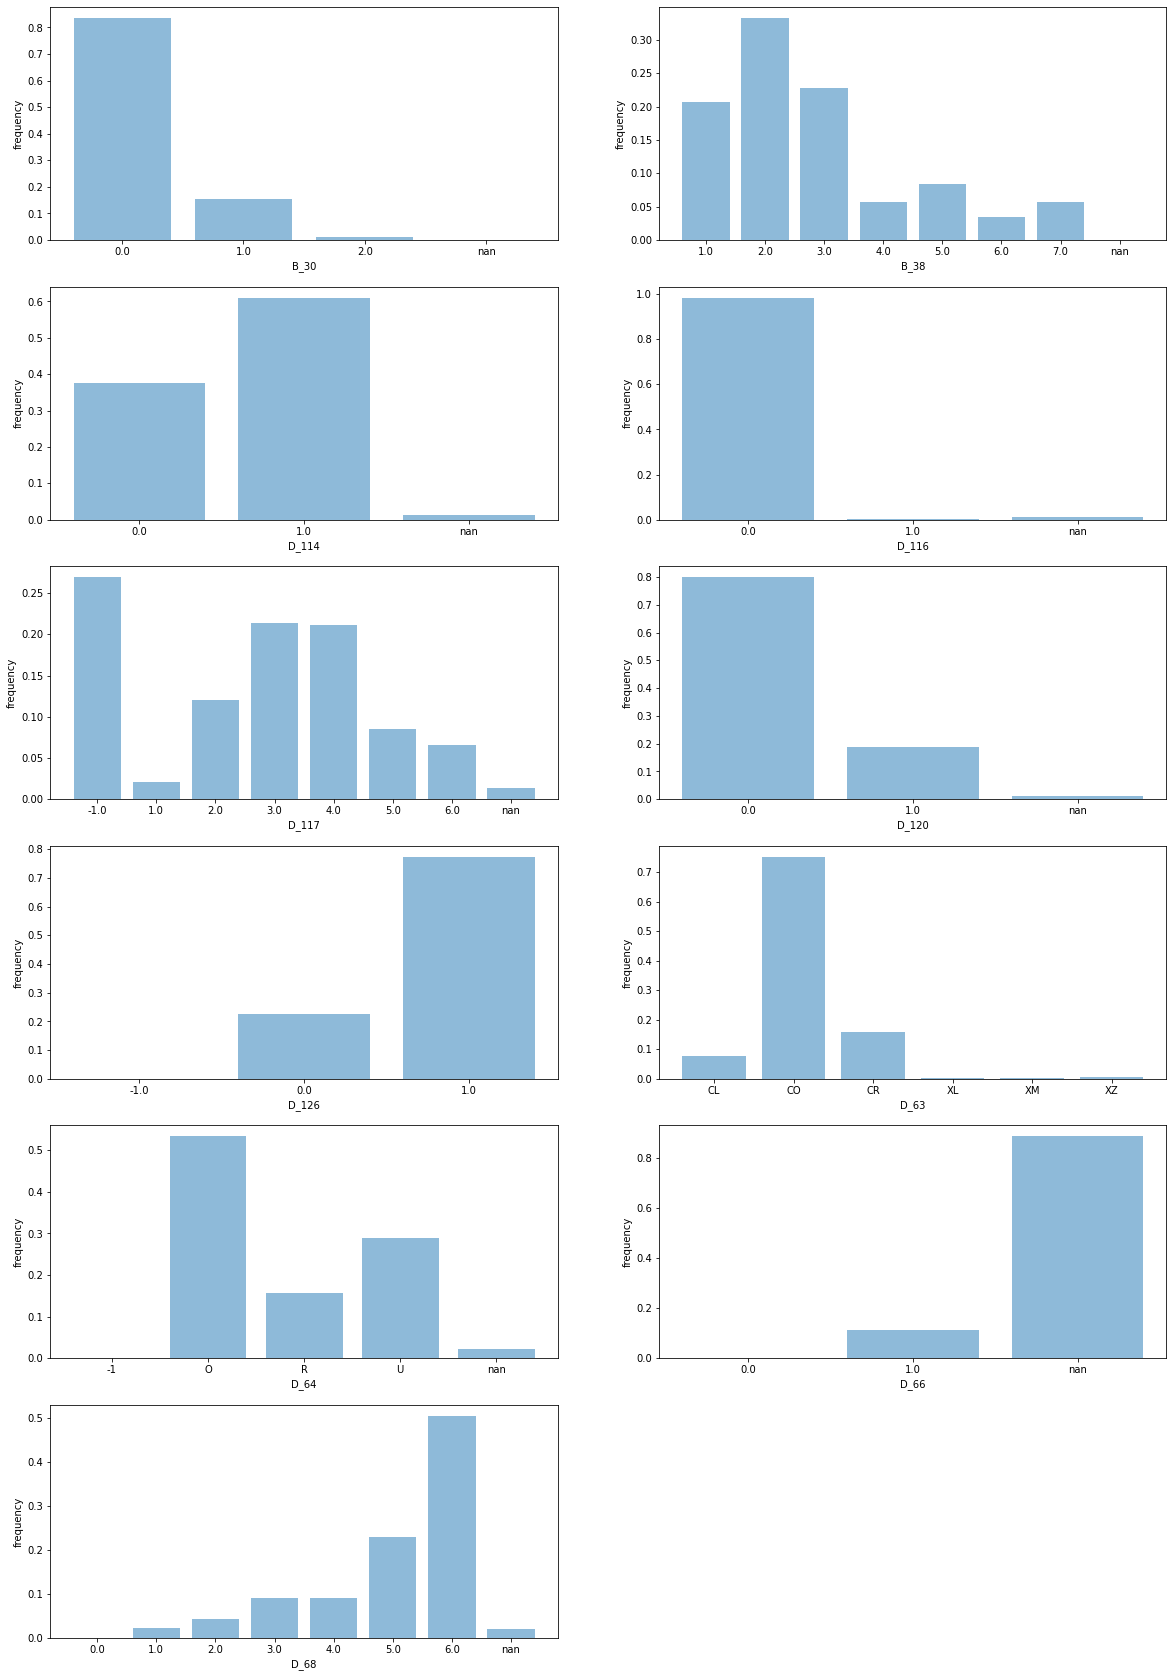

In [23]:
#visualizing categorical features
plt.figure(figsize=(20, 30))
for i, j in enumerate(categorical_cols):
    plt.subplot(6, 2, i+1)
    temp = pd.DataFrame(df_train[j].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5)
    plt.xlabel(j)
    plt.ylabel('frequency')
    plt.xticks(temp.index, temp.value)
plt.show()

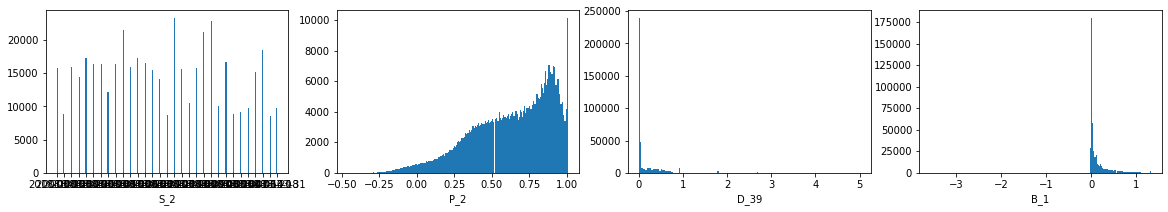

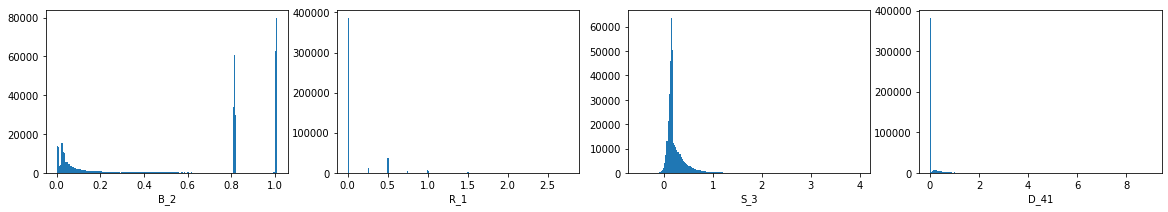

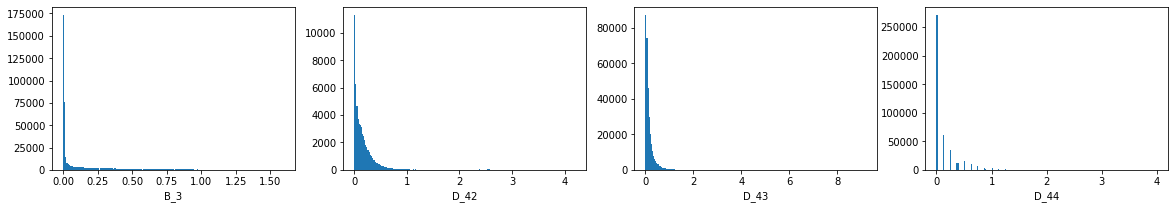

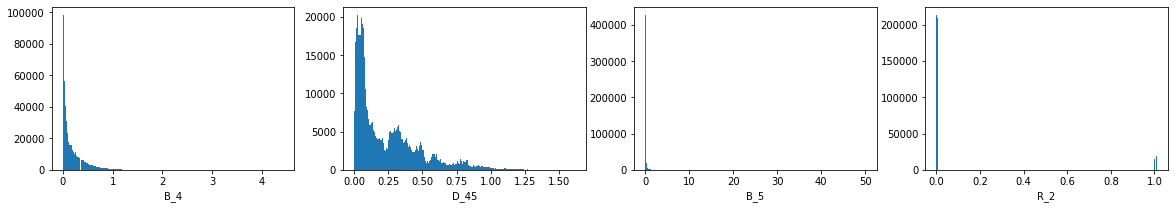

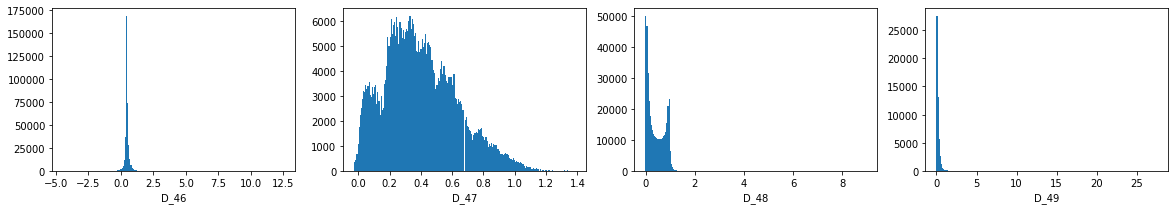

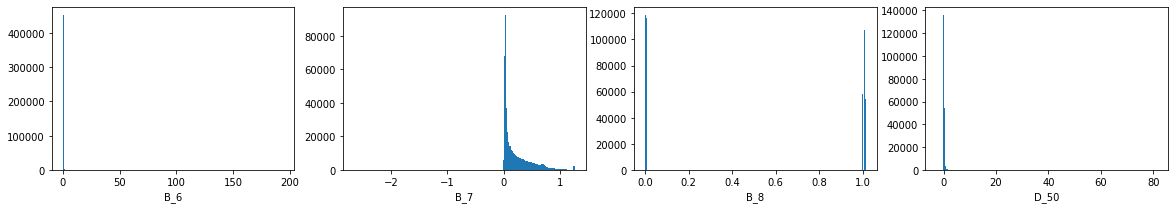

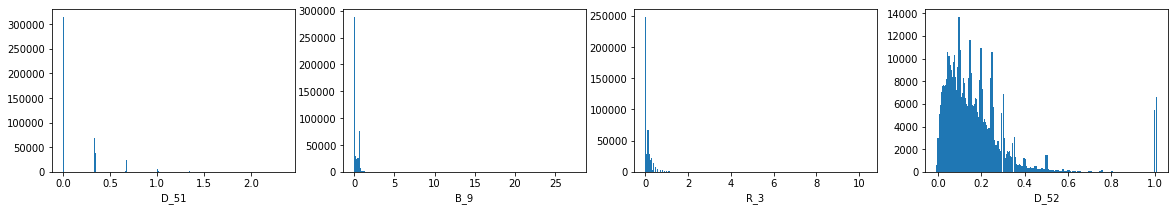

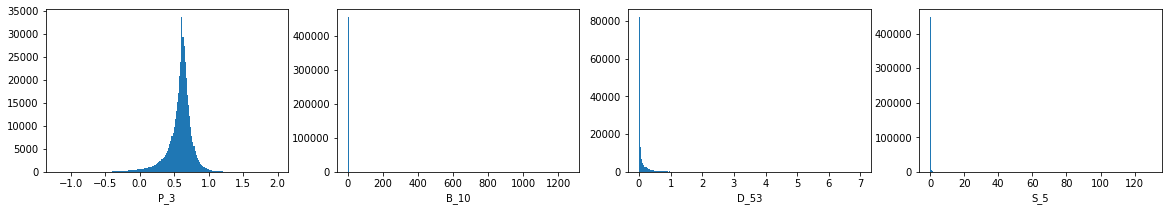

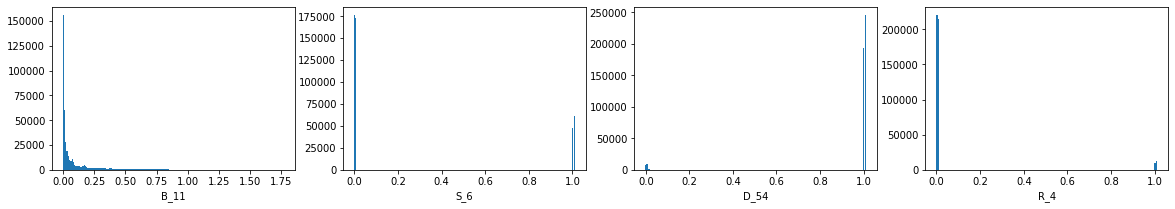

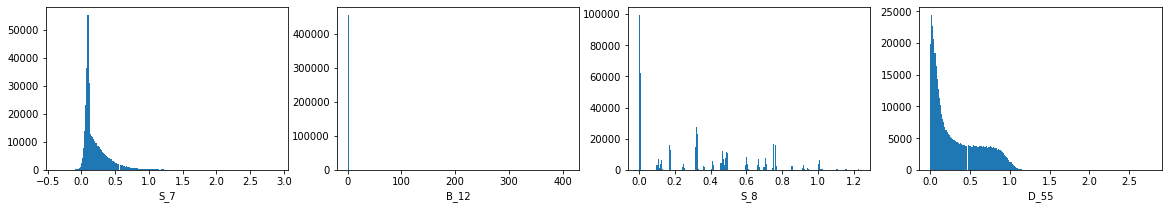

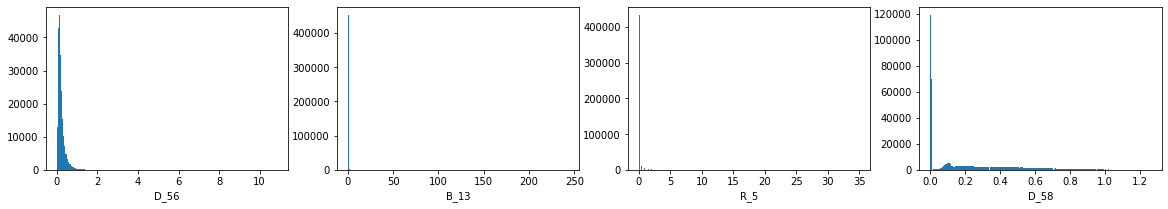

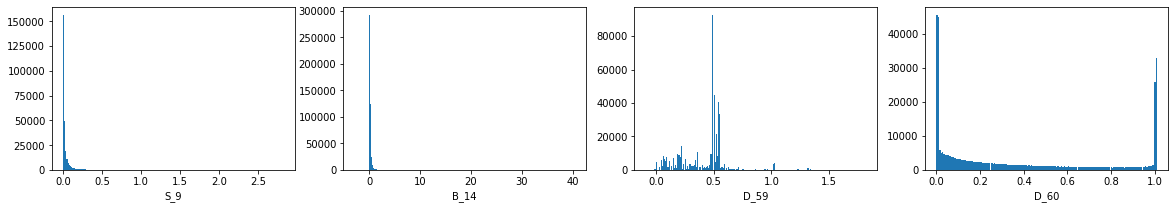

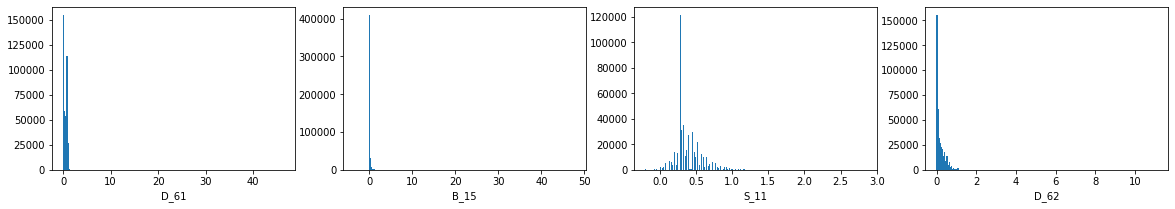

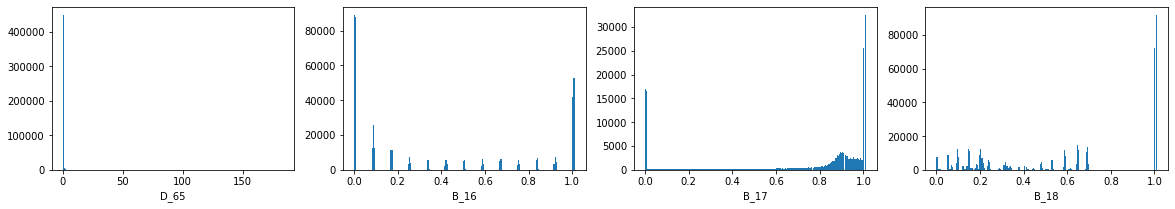

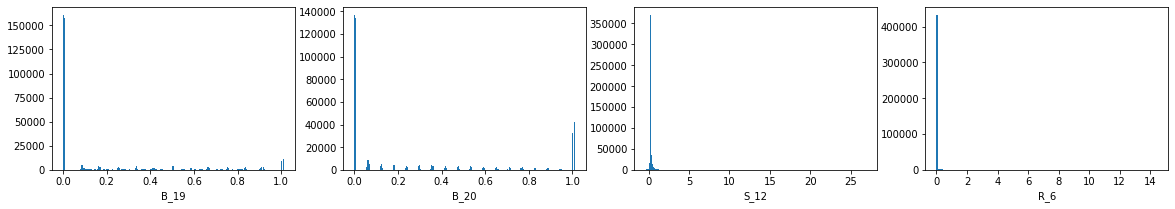

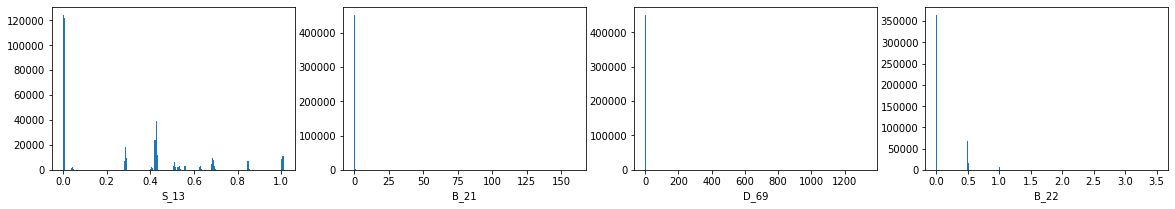

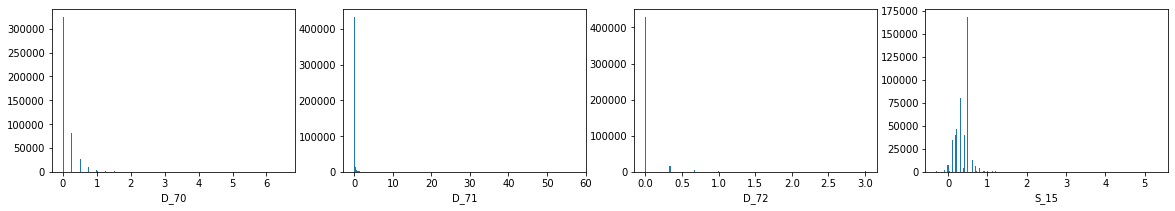

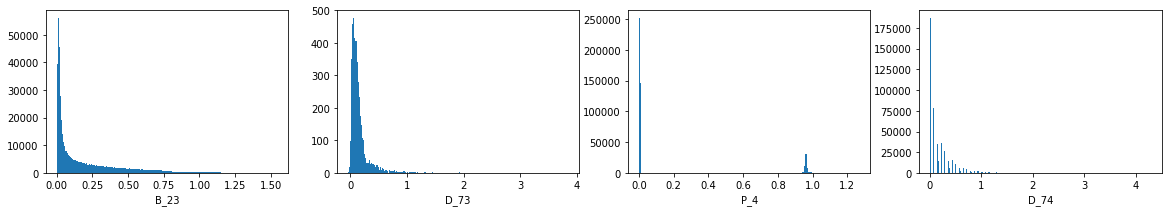

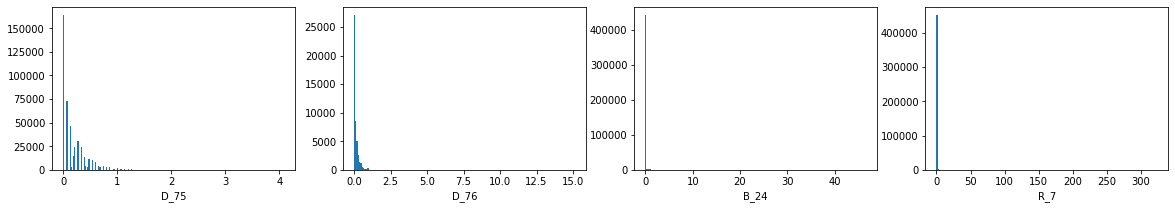

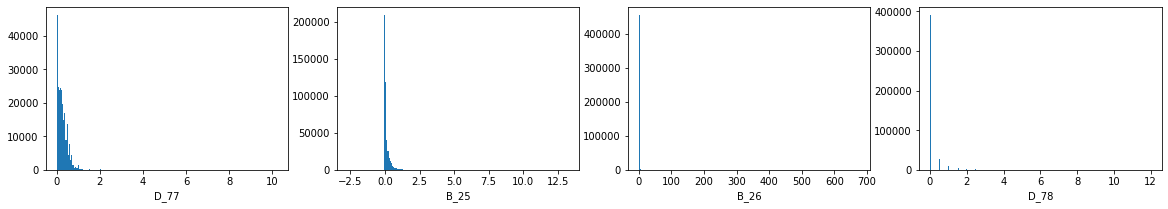

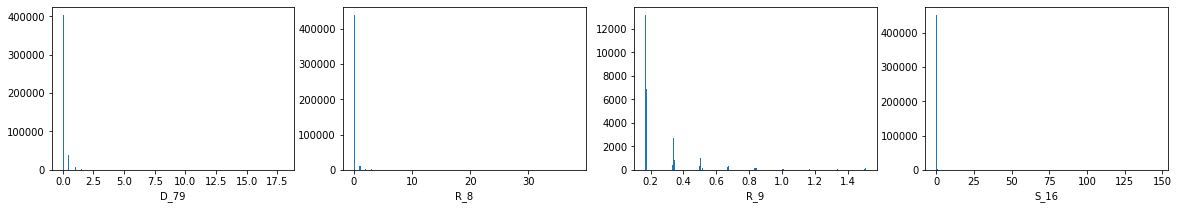

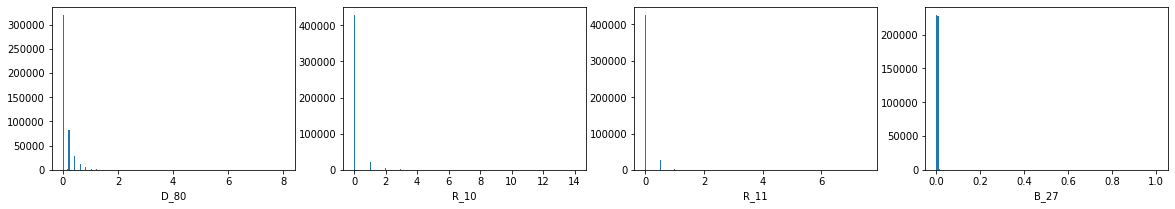

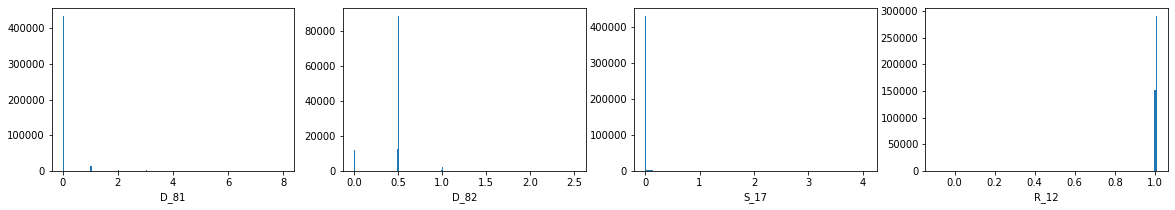

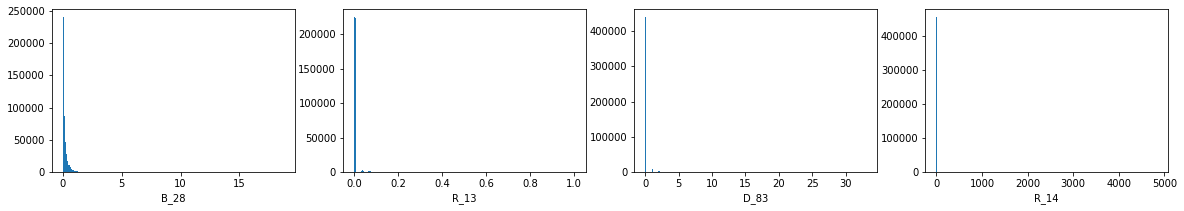

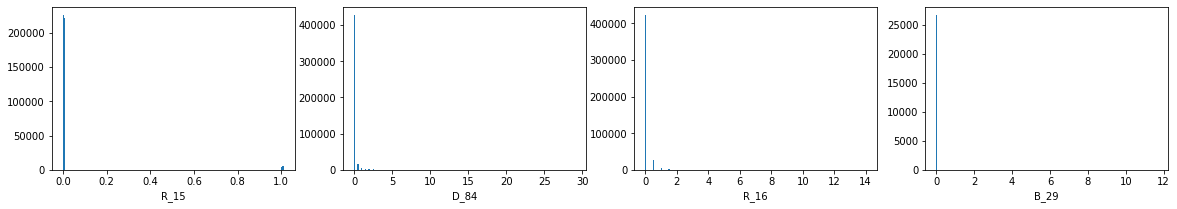

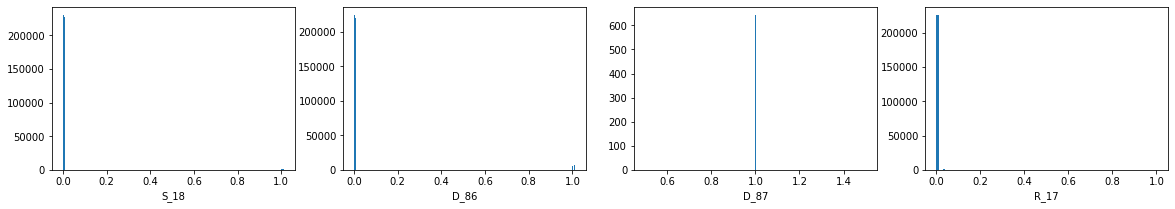

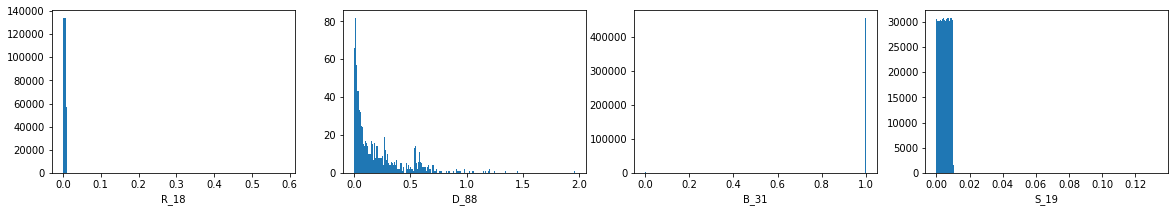

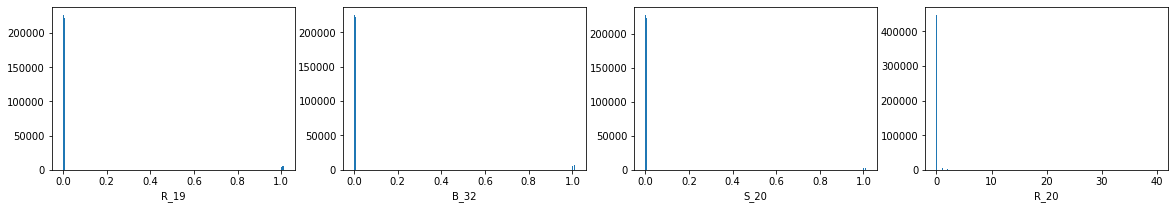

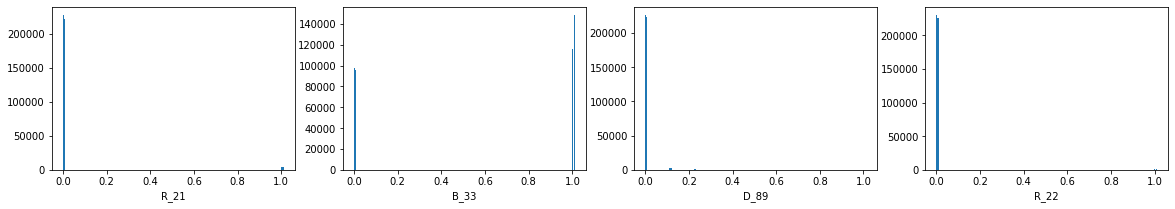

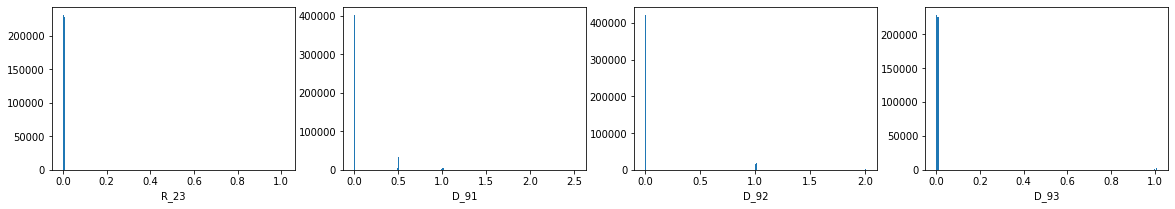

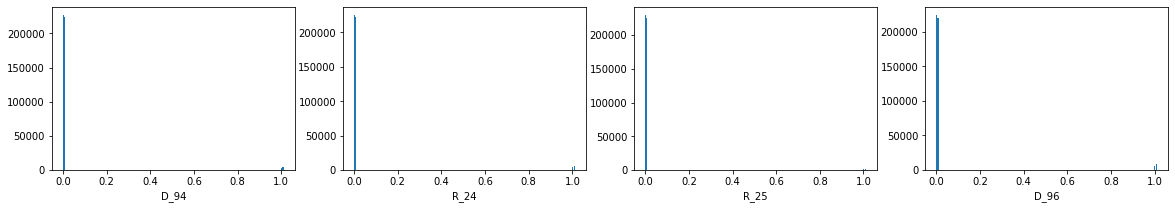

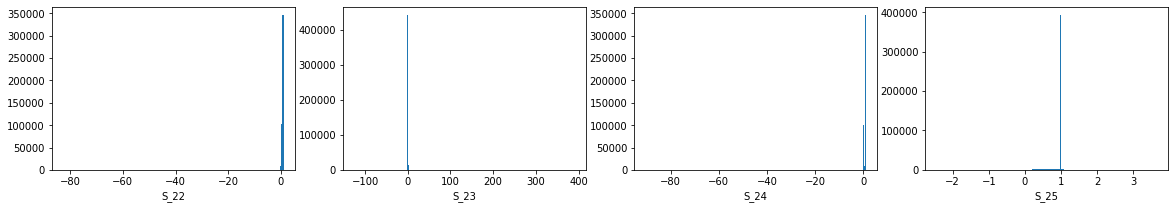

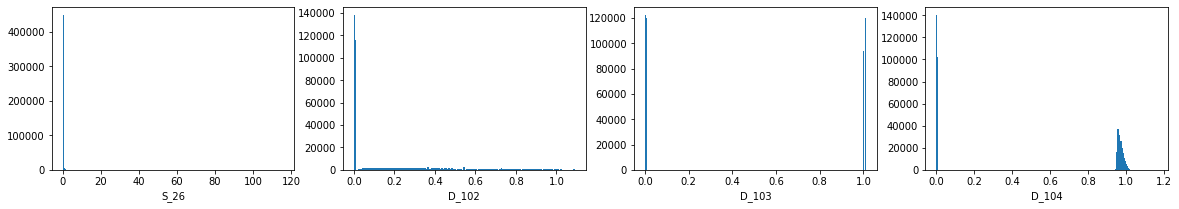

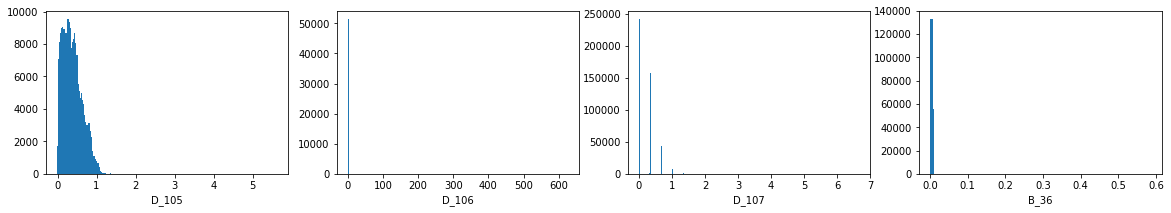

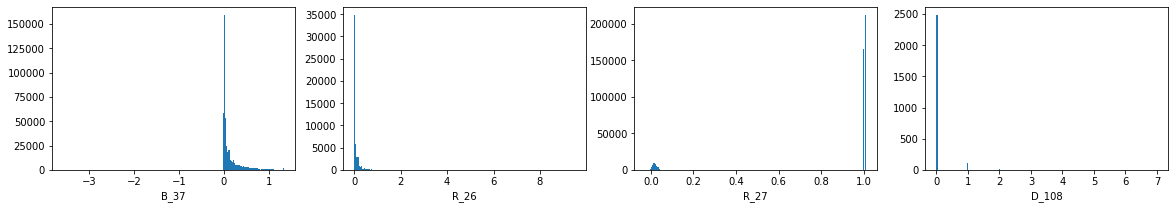

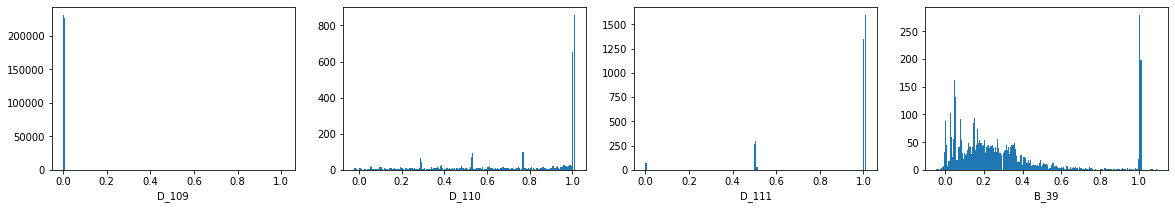

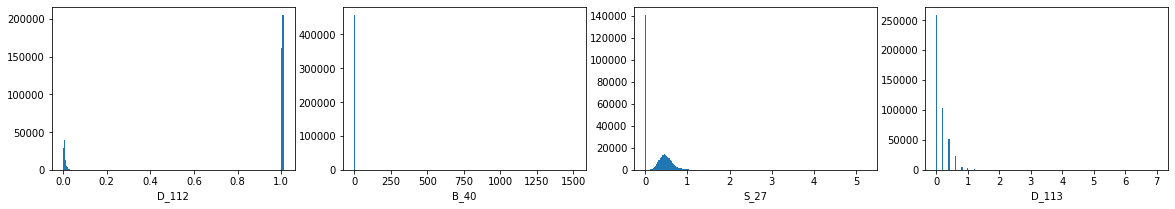

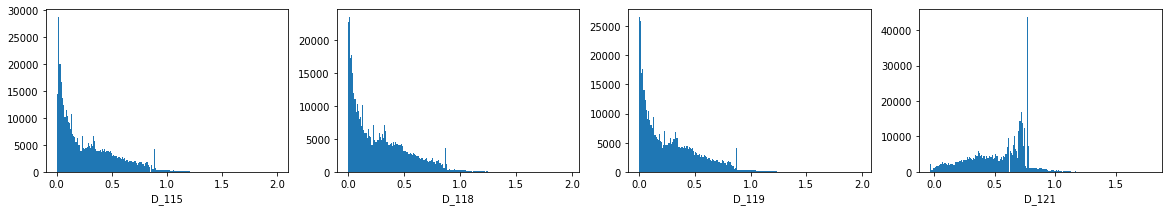

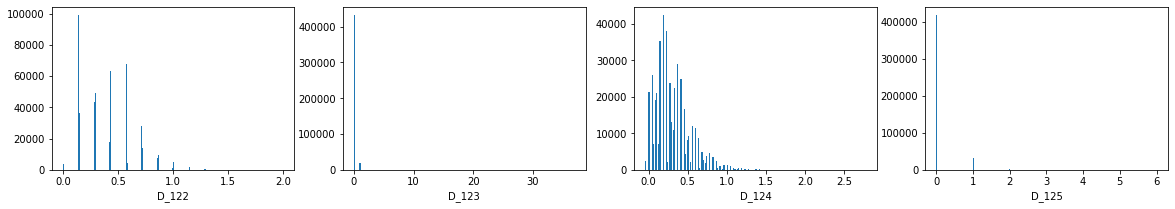

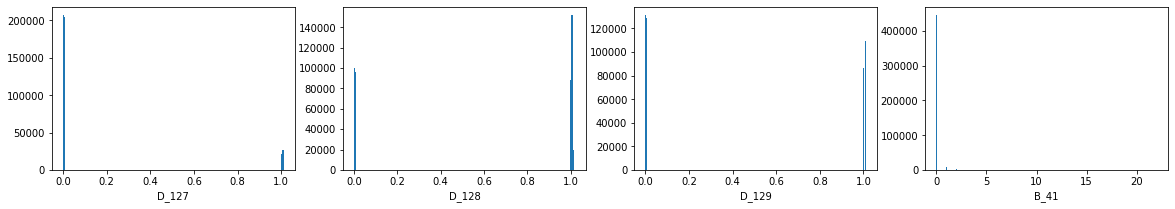

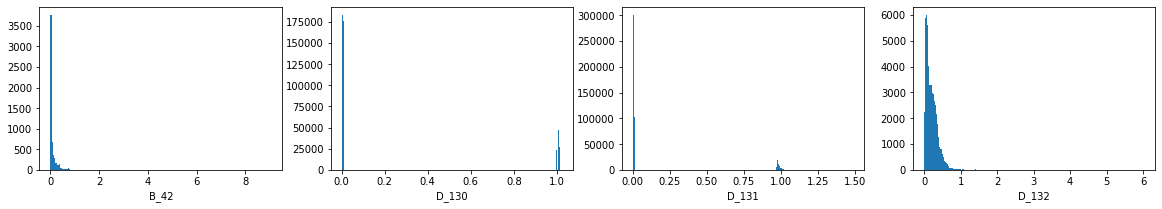

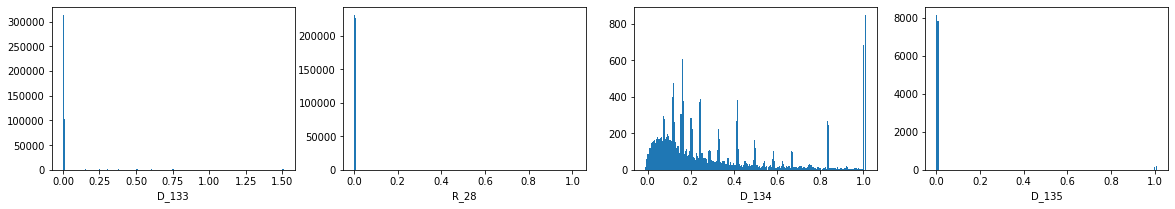

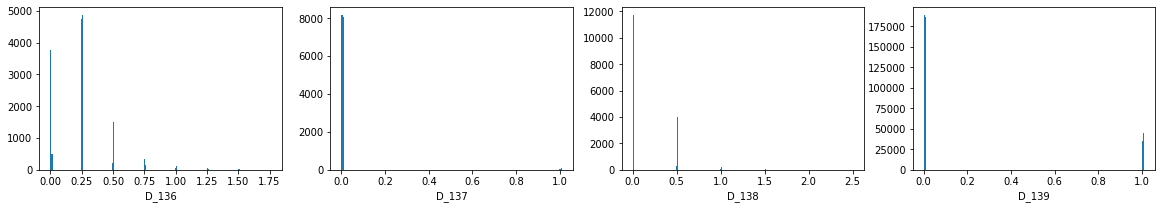

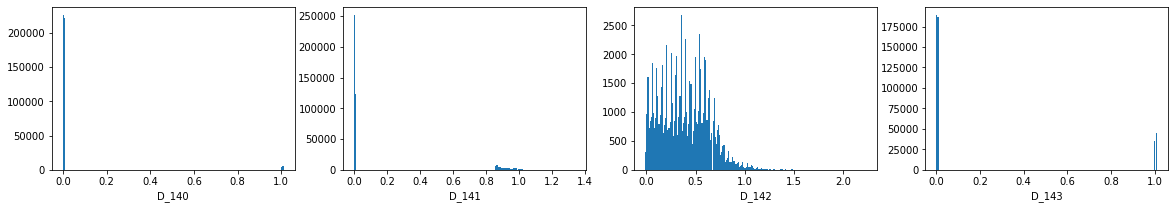

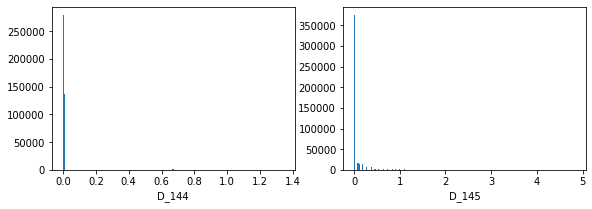

In [24]:
#Visualizing continuous features
for i, j in enumerate(num_cols):
    if i % 4 == 0: 
        if i > 0: plt.show()
        plt.figure(figsize=(20, 3))
    plt.subplot(1, 4, i % 4 + 1)
    plt.hist(df_train[j], bins=200)
    plt.xlabel(j)
plt.show()

## Null values handling

### Train dataset

In [13]:
NaN_Values = np.array(df_train.isnull().sum())
NaN_Percentage = np.array((df_train.isnull().sum() * 100 / len(df_train)).round(2))
df_nan = pd.DataFrame([np.array(list(df_train.columns)).T,NaN_Values.T,NaN_Percentage.T,np.array(list(df_train.dtypes)).T], index=['Features','Num of Missing values','Percentage','DataType']
).transpose()
pd.set_option('display.max_rows', None)
df_nan

,Features,Num of Missing values,Percentage,DataType
0,S_2,0,0.0,object
1,P_2,2969,0.65,float16
2,D_39,0,0.0,float16
3,B_1,0,0.0,float16
4,B_2,31,0.01,float16
5,R_1,0,0.0,float16
6,S_3,84970,18.52,float16
7,D_41,31,0.01,float16
8,B_3,31,0.01,float16
9,D_42,399003,86.95,float16


In [14]:
#drop columns with 80% or more null values and S_2 column
df_train = df_train.drop(['S_2','D_66','D_42','D_49','D_73','D_76','R_9','B_29','D_87','D_88','D_106','R_26','D_108','D_110','D_111','B_39','B_42','D_132','D_134','D_135','D_136','D_137','D_138','D_142'], axis=1)

In [15]:
#Fill null values
selected_col = np.array(['P_2','S_3','B_2','D_41','D_43','B_3','D_44','D_45','D_46','D_48','D_50','D_53','S_7','D_56','S_9','B_6','B_8','D_52','P_3','D_54','D_55','B_13','D_59','D_61','B_15','D_62','B_16','B_17','D_77','B_19','B_20','D_69','B_22','D_70','D_72','D_74','R_7','B_25','B_26','D_78','D_79','D_80','B_27','D_81','R_12','D_82','D_105','S_27','D_83','R_14','D_84','D_86','R_20','B_33','D_89','D_91','S_22','S_23','S_24','S_25','S_26','D_102','D_103','D_104','D_107','B_37','R_27','D_109','D_112','B_40','D_113','D_115','D_118','D_119','D_121','D_122','D_123','D_124','D_125','D_128','D_129','B_41','D_130','D_131','D_133','D_139','D_140','D_141','D_143','D_144','D_145'])

for col in selected_col:
    df_train[col] = df_train[col].fillna(df_train[col].median())

In [16]:
selcted_col2 = np.array(['D_68','B_30','B_38','D_64','D_114','D_116','D_117','D_120','D_126'])

for col2 in selcted_col2:
    df_train[col2] =  df_train[col2].fillna(df_train[col2].mode()[0])

In [17]:
print(df_train.isnull().sum().to_string())

P_2      0
D_39     0
B_1      0
B_2      0
R_1      0
S_3      0
D_41     0
B_3      0
D_43     0
D_44     0
B_4      0
D_45     0
B_5      0
R_2      0
D_46     0
D_47     0
D_48     0
B_6      0
B_7      0
B_8      0
D_50     0
D_51     0
B_9      0
R_3      0
D_52     0
P_3      0
B_10     0
D_53     0
S_5      0
B_11     0
S_6      0
D_54     0
R_4      0
S_7      0
B_12     0
S_8      0
D_55     0
D_56     0
B_13     0
R_5      0
D_58     0
S_9      0
B_14     0
D_59     0
D_60     0
D_61     0
B_15     0
S_11     0
D_62     0
D_63     0
D_64     0
D_65     0
B_16     0
B_17     0
B_18     0
B_19     0
B_20     0
D_68     0
S_12     0
R_6      0
S_13     0
B_21     0
D_69     0
B_22     0
D_70     0
D_71     0
D_72     0
S_15     0
B_23     0
P_4      0
D_74     0
D_75     0
B_24     0
R_7      0
D_77     0
B_25     0
B_26     0
D_78     0
D_79     0
R_8      0
S_16     0
D_80     0
R_10     0
R_11     0
B_27     0
D_81     0
D_82     0
S_17     0
R_12     0
B_28     0
R_13     0

In [30]:
df_train.shape

(458913, 165)

### Test dataset

In [18]:
NaN_Values1 = np.array(df_test.isnull().sum())
NaN_Percentage1 = np.array((df_test.isnull().sum() * 100 / len(df_test)).round(2))
df_nan1 = pd.DataFrame([np.array(list(df_test.columns)).T,NaN_Values1.T,NaN_Percentage1.T,np.array(list(df_test.dtypes)).T], index=['Features','Num of Missing values','Percentage','DataType']
).transpose()
pd.set_option('display.max_rows', None)

df_nan1

,Features,Num of Missing values,Percentage,DataType
0,S_2,0,0.0,object
1,P_2,4784,0.52,float16
2,D_39,0,0.0,float16
3,B_1,0,0.0,float16
4,B_2,43,0.0,float16
5,R_1,0,0.0,float16
6,S_3,144280,15.6,float16
7,D_41,43,0.0,float16
8,B_3,43,0.0,float16
9,D_42,827578,89.5,float16


In [19]:
df_test = df_test.drop(['S_2','D_42','D_49','D_66','D_73','D_76','R_9','B_29','D_87','D_88','D_106','R_26','D_108','D_110','D_111','B_39','B_42','D_132','D_134','D_135','D_136','D_137','D_138','D_142'], axis=1)

In [20]:
selected_column = np.array(['P_2','S_3','B_2','D_41','D_43','B_3','D_44','D_45','D_46','D_48','D_50','D_53','S_7','D_56','S_9','S_12','S_17','B_6','B_8','D_52','P_3','D_54','D_55','B_13','D_59','D_61','B_15','D_62','B_16','B_17','D_77','B_19','B_20','D_69','B_22','D_70','D_72','D_74','R_7','B_25','B_26','D_78','D_79','D_80','B_27','D_81','R_12','D_82','D_105','S_27','D_83','R_14','D_84','D_86','R_20','B_33','D_89','D_91','S_22','S_23','S_24','S_25','S_26','D_102','D_103','D_104','D_107','B_37','R_27','D_109','D_112','B_40','D_113','D_115','D_118','D_119','D_121','D_122','D_123','D_124','D_125','D_128','D_129','B_41','D_130','D_131','D_133','D_139','D_140','D_141','D_143','D_144','D_145'])

for column in selected_column:
    df_test[column] = df_test[column].fillna(df_test[column].median())

In [21]:
selected_column2 = np.array(['D_68','B_30','B_38','D_64','D_114','D_116','D_117','D_120','D_126'])

for column2 in selected_column2:
    df_test[column2] =  df_test[column2].fillna(df_test[column2].mode()[0])

In [22]:
print(df_test.isnull().sum().to_string())

P_2      0
D_39     0
B_1      0
B_2      0
R_1      0
S_3      0
D_41     0
B_3      0
D_43     0
D_44     0
B_4      0
D_45     0
B_5      0
R_2      0
D_46     0
D_47     0
D_48     0
B_6      0
B_7      0
B_8      0
D_50     0
D_51     0
B_9      0
R_3      0
D_52     0
P_3      0
B_10     0
D_53     0
S_5      0
B_11     0
S_6      0
D_54     0
R_4      0
S_7      0
B_12     0
S_8      0
D_55     0
D_56     0
B_13     0
R_5      0
D_58     0
S_9      0
B_14     0
D_59     0
D_60     0
D_61     0
B_15     0
S_11     0
D_62     0
D_63     0
D_64     0
D_65     0
B_16     0
B_17     0
B_18     0
B_19     0
B_20     0
D_68     0
S_12     0
R_6      0
S_13     0
B_21     0
D_69     0
B_22     0
D_70     0
D_71     0
D_72     0
S_15     0
B_23     0
P_4      0
D_74     0
D_75     0
B_24     0
R_7      0
D_77     0
B_25     0
B_26     0
D_78     0
D_79     0
R_8      0
S_16     0
D_80     0
R_10     0
R_11     0
B_27     0
D_81     0
D_82     0
S_17     0
R_12     0
B_28     0
R_13     0

In [36]:
df_test.shape

(924621, 165)

## Convert categorical variables to numbers

In [23]:
enc = OrdinalEncoder()
categorical_cols.remove('D_66')

df_train[categorical_cols] = enc.fit_transform(df_train[categorical_cols])
df_test[categorical_cols] = enc.transform(df_test[categorical_cols])

## Remove highly correlated features

In [24]:
cor_matrix = df_train.corr()
col_core = set()

for i in range(len(cor_matrix.columns)):
    for j in range(i):
        if(cor_matrix.iloc[i, j] > 0.9):
            col_name = cor_matrix.columns[i]
            col_core.add(col_name)
col_core

{'B_11',
 'B_13',
 'B_15',
 'B_23',
 'B_33',
 'B_37',
 'D_104',
 'D_119',
 'D_141',
 'D_143',
 'D_74',
 'D_75',
 'D_77',
 'S_24',
 'S_7'}

In [25]:
df_train = df_train.drop(col_core, axis=1)
df_test = df_test.drop(col_core, axis=1)

In [40]:
df_train.shape

(458913, 150)

In [41]:
df_test.shape

(924621, 150)

## Train model

In [26]:
num_columns = [col for col in df_train.columns]

X = df_train
y = df_label.target

print(f"X shape is = {X.shape}" )
print(f"Y shape is = {y.shape}" )

X shape is = (458913, 150)
Y shape is = (458913,)


In [27]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape is = {X_train.shape}" )
print(f"Y_train shape is = {y_train.shape}" )
print(f"X_test shape is = {X_test.shape}" )
print(f"Y_test shape is = {y_test.shape}" )

X_train shape is = (367130, 150)
Y_train shape is = (367130,)
X_test shape is = (91783, 150)
Y_test shape is = (91783,)


In [28]:
# From https://www.kaggle.com/code/inversion/amex-competition-metric-python
# evaluation metric
def amex_metric(y_true, y_pred, return_components=False) -> float:
    """Amex metric for ndarrays"""
    
    def top_four_percent_captured(df) -> float:
        """Corresponds to the recall for a threshold of 4 %"""
        
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
    
    
    def weighted_gini(df) -> float:
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()
    
    def normalized_weighted_gini(df) -> float:
        """Corresponds to 2 * AUC - 1"""
        
        df2 = pd.DataFrame({'target': df.target, 'prediction': df.target})
        df2.sort_values('prediction', ascending=False, inplace=True)
        return weighted_gini(df) / weighted_gini(df2)

    
    df = pd.DataFrame({'target': y_true.ravel(), 'prediction': y_pred.ravel()})
    df.sort_values('prediction', ascending=False, inplace=True)
    g = normalized_weighted_gini(df)
    d = top_four_percent_captured(df)

    if return_components: return g, d, 0.5 * (g + d)
    return 0.5 * (g + d)


In [29]:
sample_dataset = pd.read_csv('/kaggle/input/amex-default-prediction/sample_submission.csv')

## LightGBM

In [45]:
import lightgbm as lgb

In [46]:
d_train = lgb.Dataset(X_train, label=y_train, categorical_feature = categorical_cols)
params = {'objective': 'binary',
          'n_estimators': 5000,
          'metric': 'binary_logloss',
          'boosting': 'gbdt',
          'num_leaves': 100,
          'reg_lambda' : 50,
          'colsample_bytree': 0.19,
          'learning_rate': 0.01,
          'min_child_samples': 2400,
          'max_bins': 511,
          'seed': 42,
          'verbose': -1,
         }
model_lgb = lgb.train(params, d_train, 100)
predictions_lgb = model_lgb.predict(X_test[num_columns])

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


In [47]:
predictions_lgb

array([1.10646738e-01, 9.59047641e-03, 2.51873761e-04, ...,
       9.13324046e-04, 1.94580995e-02, 7.04327549e-01])

In [48]:
amex_score_lightgbm = amex_metric(y_test.values, predictions_lgb, return_components = False)
amex_score_lightgbm
#0.7907344220477854

0.7913031995436184

In [52]:
predictions_lightgbm = model_lgb.predict(df_test[num_columns])
predictions_lightgbm

array([0.01355989, 0.00197699, 0.02525905, ..., 0.49343044, 0.15308549,
       0.04525872])

In [53]:
output = pd.DataFrame({'customer_ID': sample_dataset.customer_ID, 'prediction': predictions_lightgbm})
output.to_csv('submission_lightgbm_3.csv', index=False)

## KNN

In [30]:
# import KNeighbors ClaSSifier from sklearn
from sklearn.neighbors import KNeighborsClassifier

In [31]:
# instantiate the model with k=5
knn_5 = KNeighborsClassifier(n_neighbors=5)


# fit the model to the training set
knn_5.fit(X_train, y_train)


# predict on the test-set
y_pred_5 = knn_5.predict(X_test)
amex_score_knn_5 = amex_metric(y_test.values, y_pred_5, return_components = False)
amex_score_knn_5

0.4834488788562281

In [32]:
predictions_knn = knn_5.predict(df_test[num_columns])
predictions_knn

array([0, 0, 0, ..., 0, 0, 0])

In [34]:
output_knn = pd.DataFrame({'customer_ID': sample_dataset.customer_ID, 'prediction': predictions_knn})
output_knn.to_csv('submission_knn.csv', index=False)

## SVM

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

In [34]:
st_scaler = StandardScaler()
X_train_norm = st_scaler.fit_transform(X_train)
X_test_norm = st_scaler.fit_transform(X_test)

In [35]:
param_grid = { 
    'C': [6,7,8],
}

In [44]:
clf = LinearSVC(class_weight='balanced', dual=False, penalty = "l1", random_state = 42)
random_svc = GridSearchCV(estimator = clf, param_grid = param_grid, cv=2, verbose=0, n_jobs = -1)
random_svc.fit(X_train_norm,y_train)
model_svc = random_svc.best_estimator_

In [39]:
y_pred_svm = model_svc.predict(X_test_norm)


amex_score_svm = amex_metric(y_test, y_pred_svm, return_components=False)
amex_score_svm

0.5230167384406333

In [41]:
predictions_svm = model_svc.predict(df_test[num_columns])
predictions_svm

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([0, 0, 0, ..., 0, 0, 0])

In [42]:
output_svm = pd.DataFrame({'customer_ID': sample_dataset.customer_ID, 'prediction': predictions_svm})
output_svm.to_csv('submission_svm.csv', index=False)